# Imports 

In [1]:
from tqdm import tqdm

In [11]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from phenoseeker import BioproxyEvaluator
import pandas as pd
import seaborn as sns

In [ ]:
screens_folders = {
    "ChEMBL": Path("/projects/synsight/repos/phenoseeker/data/ChEMBL/assays_csv"),
    "Lit-PCBA": Path("/projects/synsight/repos/phenoseeker/data/Lit_PCBA/csv_files"),
}

In [ ]:
base_path = Path("/projects/synsight/data/jump_embeddings/compounds_embeddings/")
model = "dinov2_g"
npy_file = base_path / model / "Embeddings_norm.npy"
parquet_metadata = base_path / model / Path("metadata.parquet")

In [5]:
eval = BioproxyEvaluator(
    parquet_metadata,
    npy_file,
    screens_folders,
    embeddings_name=f"Embeddings_{model}",
    embeddings_entity="compound",
)

In [6]:
eval

BioproxyEvaluator with 3 sources (Curie: 16 screens, ChEMBL: 49 screens, Lit-PCBA: 5 screens)

In [8]:
df_screens = []
for screen in tqdm(
    eval.screen_embedding_managers["ChEMBL"],
    desc=f"Processing screens",
):
    df_screens.append(
        eval.compute_enrichment_factor_for_screen(
            source="ChEMBL",
            screen=screen,
            embeddings_name="Embeddings_dinov2_g",
            thresholds=[5],
        )
    )

Processing screens: 100%|██████████| 49/49 [00:29<00:00,  1.63it/s]


In [9]:
def plot_normalized_ef_per_screen_with_points(df_screens_list, label, figsize=(12, 6)):
    """
    df_screens_list: list of DataFrames (one per screen) with columns:
      ['Screen','Normalized_EF','Hit Rate Random','N Hits','N Compounds']
    """
    df_all = pd.concat(df_screens_list, ignore_index=True)

    # Meta rows per screen (assume constant per screen)
    df_meta = (
        df_all.groupby("Screen")
        .agg(
            hit_rate_random=("Hit Rate Random", "first"),
            n_hits=("N Hits", "first"),
            n_compounds=("N Compounds", "first"),
        )
        .reset_index()
    )

    # --- Sort by hit_rate_random ---
    df_meta = df_meta.sort_values("hit_rate_random", ascending=True).reset_index(
        drop=True
    )
    screen_order = df_meta["Screen"].tolist()
    df_all["Screen"] = pd.Categorical(
        df_all["Screen"], categories=screen_order, ordered=True
    )

    plt.figure(figsize=figsize, dpi=500)
    ax = plt.gca()

    # Boxplots
    sns.boxplot(
        data=df_all,
        x="Screen",
        y="Normalized_EF",
        order=screen_order,  # enforce sorted order
        palette="Set3",
        fliersize=0,
        width=0.6,
        ax=ax,
    )

    # Overlay all single values
    sns.stripplot(
        data=df_all,
        x="Screen",
        y="Normalized_EF",
        order=screen_order,
        color="k",
        alpha=0.35,
        size=2.5,
        jitter=0.28,
        dodge=False,
        ax=ax,
    )

    # Red dashed baselines + annotations
    y_min, y_max = ax.get_ylim()
    y_span = y_max - y_min
    label_offsets = [0.025, 0.055, 0.085, 0.115]

    for i, row in df_meta.iterrows():
        y0 = row["hit_rate_random"] * 100.0
        ax.hlines(
            y0,
            xmin=i - 0.38,
            xmax=i + 0.38,
            colors="red",
            linestyles="--",
            linewidth=1.2,
        )
        y_text = y0 + label_offsets[i % len(label_offsets)] * y_span
        ax.text(
            i,
            y_text,
            f"{int(row['n_hits'])} / {int(row['n_compounds'])}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="red",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
        )

    # Cosmetics
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_ylabel("Normalized EF@5%")
    ax.set_title(f"Distribution of Normalized EF per Screen for {label}")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, axis="y", linewidth=0.3, alpha=0.5)

    plt.tight_layout()
    plt.show()

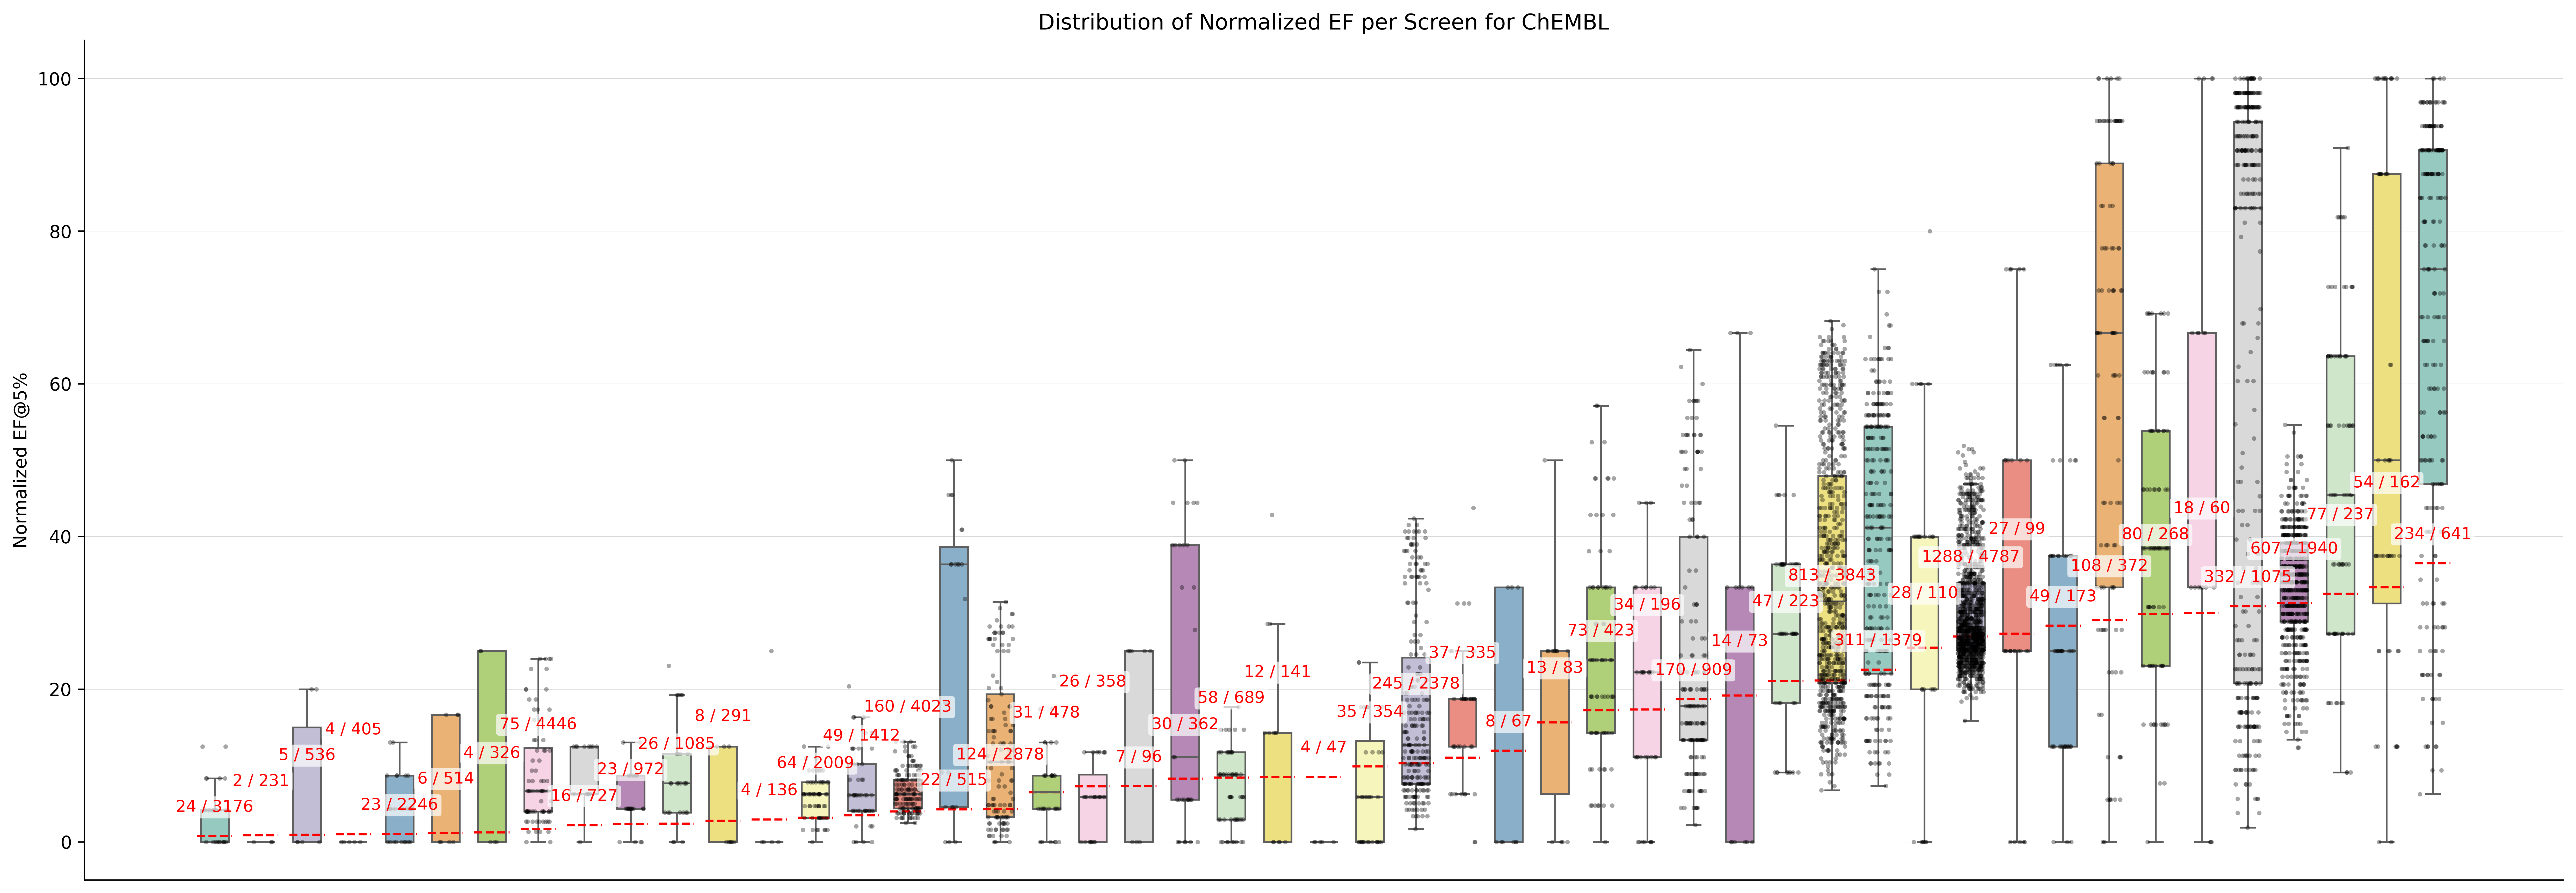

In [12]:
plot_normalized_ef_per_screen_with_points(df_screens, "ChEMBL", figsize=(20, 7))